In [2]:
# Basic Imports
import pathlib
from pathlib import Path
import os
import sys
from typing import Any, Sequence, Optional, Tuple, Iterator, Dict, Callable, Union
import json
import time
from tqdm.auto import tqdm
import numpy as np
from copy import copy
from glob import glob
from collections import defaultdict
import matplotlib.pyplot as plt

# Changing fonts to be latex typesetting
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif'

# JAX/Flax
import jax
from jax import jit
import jax.numpy as jnp
from jax import random

# PyTorch for Dataloaders
import torch
import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms

# Import created functions
import make_dataset as mkds
import visualization as vis

from numpy.random import default_rng
key = random.PRNGKey(42)
rng = default_rng(np.asarray(key))

# **Goal of this Notebook**: Perturb MNIST dataset and put it into a dataloader

TODO:
- Create custom dataset that perturbs the pytorch dataset and outputs the perturbed MNIST images with the Empirical field

**NOTE:** The perturbation hyperparameters have to larger than usual when running the `process_perturbed_data` function.

- Further testing needs to be done to figure out why, but as of right now, I'll continue on and come back to this once the model is working.

In [12]:
turb_training, turb_test = mkds.create_perturbed_dataset(sigma=0.2,
                                                         tau=0.06,
                                                         M=291,
                                                         download=True)

In [13]:
def jax_visualize_field_grid(batchsize: int, 
                         sample_idx: int, 
                         x_coord: int, 
                         y_coord: int, 
                         grid_lims: int):
    """
    Function that visualizes the empirical Poisson field created by a subset
    of the data distribution (ie. the Poisson field created from the samples
    in the batch) over a uniform grid of points. The visualization takes a 2D
    slice through the N+1 dimensions that PFGM needs to learning the mapping
    input distribution to target distribution.
    
    The chosen dimensions that make up the slice is the z-dimension, which is
    the extra dimension that PFGM needs to add avoid mode collapse and a 
    user specified dimension (ie. pixel) from the target distribution (eg. 
    a pixel in MNIST). With these two dimensions we can see the vector field
    of the empirical Poisson field created by the target distribution.
    
    (INCLUDE A BETTER EXPLANATION) 

    Args:
    -----
        batchsize: int
            Number of samples in batch
        sample_idx: int
            Index of the specified sample found within the batch
        x_coord: int
            X-coordinate of the pixel of interest
        y_coord: int
            Y-coordinate of the pixel of interest
        rng: np.random.generator_.Generator
            rng used for calculating the perturbing hyperparameters
        figure_name: str
            Name of downloaded figure. 
            NOTE: the chosen extension (.png, .jpg, etc.) needs to be included
        figure_dir: str
            Path to the directory where the saved image will be stored.

    Returns:
    --------
        A two panel plot with:
            Left plot showing a sample image with a red circle
            overlaid on the chosen pixel who's E field will be
            plotted on the right (quiver) plot.

            Right plot is a quiver plot depicting the E field calculated 
            at the specified pixel value. The x/y coordinates for the points
            in the quiver plot are the (pixel_val, z_value) in the perturbed
            image and the (x/y) coordinates of the arrows are 
            (E_field @ pixel_coord, E_field & z_value)
    """
    # Create a DL with a user specified batchsize
    data, targets = turb_test[:batchsize] # Turb test is a global variable!!!!
    # Assign the images to a specific variable that we'll use for training
    vis_batch = data
    
    flat_coord = x_coord * 28 + y_coord

    # Get all the samples of the given batch EXCEPT for the element of the sample
    # that is being plotted in the left plot
    everything_except = np.arange(len(data)) != sample_idx

    fig, ax = plt.subplots(1,2, figsize=(10,8))
    ax[0].imshow(vis_batch[sample_idx][:-1].reshape((28,28)), label='Example of Input image')
    ax[0].scatter(x_coord, y_coord, color='red', s=40, label='Selected pixel')
    ax[0].set(title='Example image of selected input pixel')
    ax[0].axis('off')
    ax[0].legend()
    ax[1].quiver(data[everything_except, flat_coord], data[everything_except,-1],
                 targets[everything_except, flat_coord], targets[everything_except,-1], label='Poisson Field of other samples');
    # This quiver plot highlights the selected pixel in the left panel. Allowing the audience to see how 
    # this one pixel is mapped into the N+1 dimension above the hyperplane.
    ax[1].quiver(data[sample_idx, flat_coord], data[sample_idx,-1],
                 targets[sample_idx, flat_coord], targets[sample_idx,-1], color='red', alpha=0.7, label='This pixels Poisson Field');
    ax[1].set_title(f'Poisson field for pixel {x_coord, y_coord}')
    ax[1].set_xlabel(f'Perturbed value of pixel {x_coord, y_coord}')
    ax[1].set_ylabel(f'Z value of pixel {x_coord, y_coord}')
    ax[1].legend()
    ax[1].set_xlim(-0.5,0.5)
    ax[1].set_ylim(0,0.5)
    plt.show()

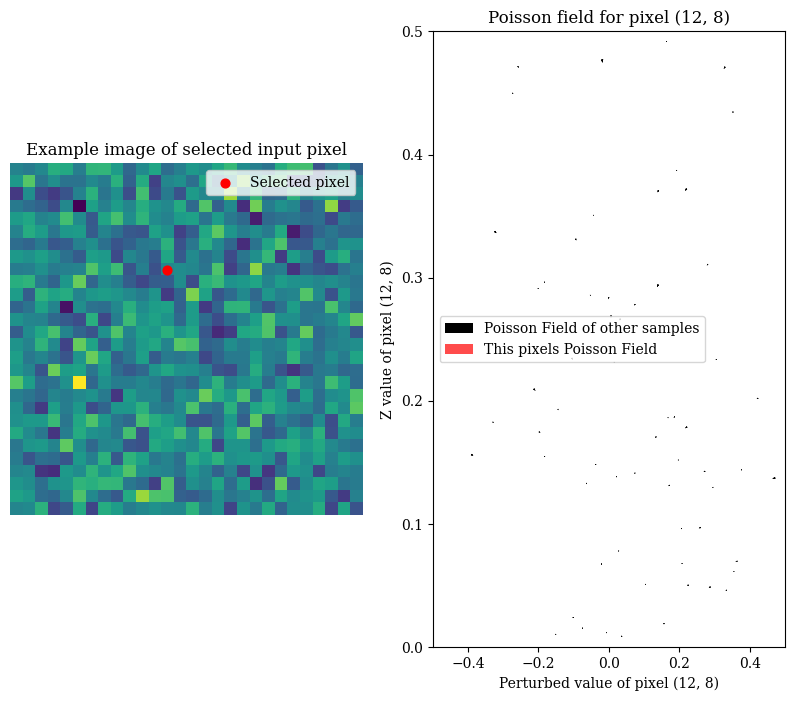

In [14]:
jax_visualize_field_grid(batchsize=400, 
                         sample_idx=0, 
                         x_coord=12, 
                         y_coord=8, 
                         grid_lims=40)

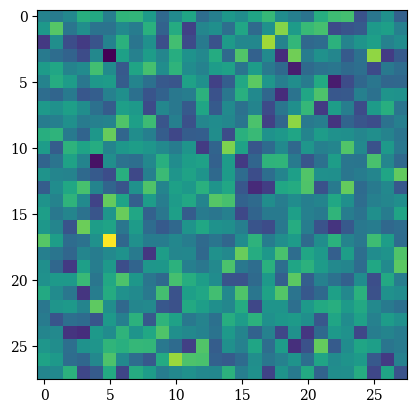

In [15]:
plt.imshow(turb_test[0][0][:784].reshape((28,28)))

In [16]:
# perturbed_training = mkds.load_data(data_dir='/pscratch/sd/m/mdowicz/PFGM_MNIST/saved_data/MNIST/perturbed/',
#                                      data_file='perturbed_training.pkl')

# perturbed_test = mkds.load_data(data_dir='/pscratch/sd/m/mdowicz/PFGM_MNIST/saved_data/MNIST/perturbed/',
#                                      data_file='perturbed_test.pkl')

In [17]:
train, val, test = mkds.partition_MNIST(perturb_on=True,
                                        download=True)

In [1]:
mkds.partition_MNIST??

Object `mkds.partition_MNIST` not found.


In [5]:
# perturbed_training = mkds.load_data(data_dir='/pscratch/sd/m/mdowicz/PFGM_MNIST/saved_data/MNIST/perturbed/partitioned',
#                                      data_file='partitioned_training_set.pkl')

# perturbed_test = mkds.load_data(data_dir='/pscratch/sd/m/mdowicz/PFGM_MNIST/saved_data/MNIST/perturbed/partitioned',
#                                      data_file='partitioned_val_set.pkl')

# perturbed_test = mkds.load_data(data_dir='/pscratch/sd/m/mdowicz/PFGM_MNIST/saved_data/MNIST/perturbed/partitioned',
#                                      data_file='partitioned_test_set.pkl')

In [11]:
train_dl, val_dl, test_dl = mkds.load_dataloaders(batch_size=128)
train_batch = next(iter(train_dl))
train_batch

(array([[-2.3419072e-01, -1.4114580e-01,  4.9423113e-01, ...,
          6.6451418e-01, -3.3932951e-01,  4.4563210e-01],
        [ 8.7947458e-01, -6.4830291e-01, -2.7263520e+00, ...,
          2.1973819e-01,  1.5693203e-02,  4.6218747e-01],
        [ 1.6634733e+01, -1.9819473e+01, -1.2040611e+01, ...,
          7.5641594e+00,  1.0853159e+01,  9.5371084e+00],
        ...,
        [ 1.0773638e+07,  4.3282505e+06,  6.2076394e+05, ...,
         -5.4915915e+06,  9.5315580e+06,  6.3002330e+06],
        [-6.2805139e+02, -6.2744209e+03, -1.4394020e+03, ...,
         -2.3543826e+03, -3.5539373e+03,  9.0490234e+02],
        [ 1.7618380e+01, -7.8495648e-03, -1.7696421e+01, ...,
          2.5498320e+01,  2.1638634e+01,  1.4103991e+01]], dtype=float32),
 array([[ 5.9174716e-01,  3.5664362e-01, -1.2488108e+00, ...,
         -1.6790776e+00,  8.5740924e-01, -1.1260118e+00],
        [-5.0120145e-01,  3.6945969e-01,  1.5537137e+00, ...,
         -1.2522602e-01, -8.9433584e-03, -2.6339483e-01],
        [-

In [12]:
for cnt, batch in enumerate(train_dl):
    print(cnt)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27